In [1]:
!pip install transformers
!pip install matplotlib scikit-learn

### Uploading the Dataset

In [2]:
from google.colab import files
import pandas as pd

# Upload the dataset
uploaded = files.upload()

# Load the dataset into a pandas dataframe
df = pd.read_csv(next(iter(uploaded)))

# Display the first few rows to understand the structure
df.head()


Saving LLM_dataset.csv to LLM_dataset.csv


,x_i,x_j,Label
0,he held her back and,"whispered urgently for her to stay calm, sensi...",GPT4o
1,none of her previous boyfriends had,had lasted this long.,GPT4o
2,"our clothes quickly disappeared , until we stood",naked in the moonlight.,GPT4o
3,but dagmar was not some mindless,follower; she had a plan.,GPT4o
4,"she paused , obviously",uncertain of what to say next.,GPT4o


### Uploading data from local LLM_dataset.csv

In [1]:
import pandas as pd
data_path = '../datasets/LLM_dataset.csv'
df = pd.read_csv(data_path)
df.head()

,x_i,x_j,Label
0,he held her back and,"whispered urgently for her to stay calm, sensi...",GPT4o
1,none of her previous boyfriends had,had lasted this long.,GPT4o
2,"our clothes quickly disappeared , until we stood",naked in the moonlight.,GPT4o
3,but dagmar was not some mindless,follower; she had a plan.,GPT4o
4,"she paused , obviously",uncertain of what to say next.,GPT4o


### Preprocessing dataset

In [2]:
# Check for missing values
df.isnull().sum()

# Combine `x_i` and `x_j` into a single text field if that’s part of your strategy
df['combined_text'] = df['x_i'] + ' ' + df['x_j']

# View a few rows of the combined text and labels
df[['combined_text', 'Label']].head()


,combined_text,Label
0,he held her back and whispered urgently for he...,GPT4o
1,none of her previous boyfriends had had lasted...,GPT4o
2,"our clothes quickly disappeared , until we sto...",GPT4o
3,but dagmar was not some mindless follower; she...,GPT4o
4,"she paused , obviously uncertain of what to sa...",GPT4o


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], df['Label'], test_size=0.2, random_state=42)


### Tokenize the dataset and convert it into a PyTorch datset

In [4]:
from transformers import DistilBertTokenizer
print(X_train[:5])
# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train = [str(text) for text in X_train]
X_test = [str(text) for text in X_test]
# Tokenize the training and testing data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')


c:\Users\YEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


23311    i was n't sure if he was stunned he was simply...
23623    foley stood in her open doorway , a candle in ...
1020      but it ties in into the greater scheme of thi...
12645    she backed up hastily , and the scarf ed her t...
1533     i unwound myself from him and could myself fro...
Name: combined_text, dtype: object


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert labels to tensors
# y_train = y_train.astype('category').cat.codes.tolist()  # Convert labels to integers
# y_test = y_test.astype('category').cat.codes.tolist()
y_train = pd.Series(y_train).astype('category').cat.codes.tolist()
y_test = pd.Series(y_test).astype('category').cat.codes.tolist()

# Create PyTorch datasets
train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### Load model

In [6]:
from transformers import DistilBertForSequenceClassification, AdamW

# Load the pre-trained DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)  # Assuming 3 labels

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\YEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### Training

In [13]:
from tqdm import tqdm

# Training loop
model.train()
for epoch in range(3):  # Train for 3 epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


  0%|          | 0/1250 [00:00<?, ?it/s]C:\Users\YEH\AppData\Local\Temp\ipykernel_26788\3953833402.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 1250/1250 [01:55<00:00, 10.83it/s, loss=0.708]


### Testing

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Put the model in evaluation mode
model.eval()

# Define the class names in the same order as the numerical labels
class_names = ['GPT2', 'GPT4o', 'GPT_NEO', 'Gemini', 'Reformer']

# Collect all predictions and labels
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(**batch)

        # Get predictions
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        # Store predictions and true labels
        preds.extend(predictions)
        true_labels.extend(labels)

# Calculate accuracy and print classification report
accuracy = accuracy_score(true_labels, preds)
print(f'Accuracy: {accuracy}')
print(classification_report(true_labels, preds, target_names=class_names))


C:\Users\YEH\AppData\Local\Temp\ipykernel_26788\3953833402.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.6724
              precision    recall  f1-score   support

        GPT2       0.54      0.54      0.54      1000
       GPT4o       0.72      0.65      0.69      1021
     GPT_NEO       0.56      0.58      0.57       989
      Gemini       0.65      0.65      0.65      1005
    Reformer       0.89      0.94      0.92       985

    accuracy                           0.67      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.67      0.67      0.67      5000



### Epoch, Batch sizes evaluation

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\YEH\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/1250 [00:00<?, ?it/s]C:\Users\YEH\AppData\Local\Temp\ipykernel_12956\3953833402.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ite

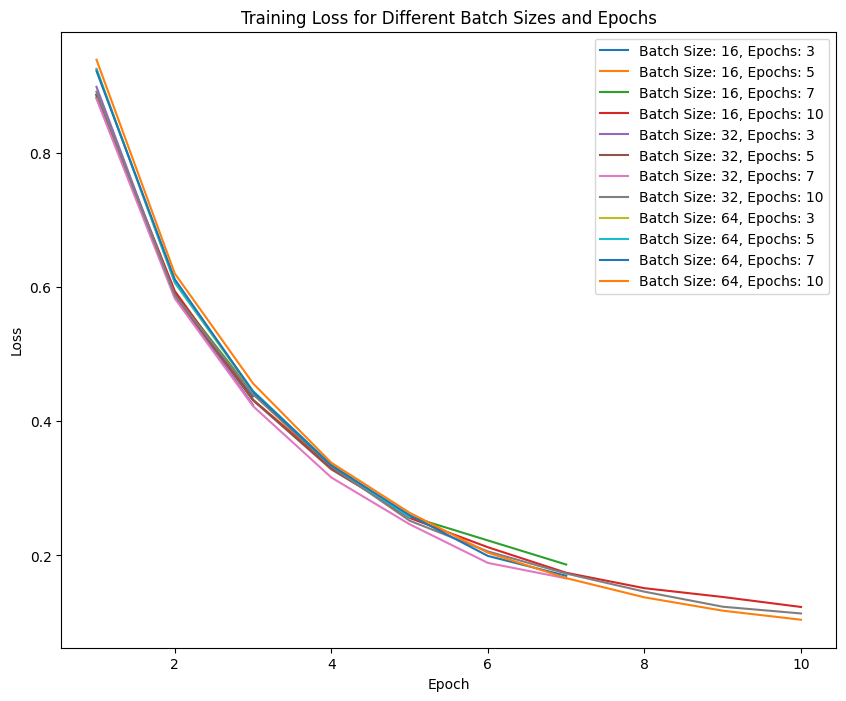

In [7]:
# %% 
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the epochs and batch sizes to evaluate
epochs_list = [3, 5, 7, 10]
batch_sizes = [16, 32, 64]

# Dictionary to store the loss history for each configuration
loss_history = {}

# Training and evaluation with different epochs and batch sizes
for batch_size in batch_sizes:
    for num_epochs in epochs_list:
        # Create DataLoader objects with the current batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # Reload the pre-trained DistilBERT model for each configuration
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
        optimizer = AdamW(model.parameters(), lr=5e-5)
        
        # Move model to GPU if available
        model.to(device)

        # Store loss history for the current configuration
        current_loss_history = []

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            loop = tqdm(train_loader, leave=True)
            epoch_loss = 0
            for batch in loop:
                # Move batch data to the same device as the model
                batch = {k: v.to(device) for k, v in batch.items()}

                # Forward pass
                outputs = model(**batch)
                loss = outputs.loss

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update progress bar and accumulate loss
                loop.set_description(f'Epoch {epoch+1}/{num_epochs}')
                loop.set_postfix(loss=loss.item())
                epoch_loss += loss.item()

            # Record the average loss for this epoch
            avg_loss = epoch_loss / len(train_loader)
            current_loss_history.append(avg_loss)
        
        # Store the loss history for this batch size and number of epochs
        loss_history[(batch_size, num_epochs)] = current_loss_history

# Visualization of loss curves for each batch size and epoch setting
plt.figure(figsize=(10, 8))
for (batch_size, num_epochs), loss_values in loss_history.items():
    plt.plot(range(1, len(loss_values) + 1), loss_values, label=f'Batch Size: {batch_size}, Epochs: {num_epochs}')

# Plot formatting
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Batch Sizes and Epochs')
plt.legend(loc='upper right')
plt.show()

### Some sample outputs

In [10]:
import random

# X_test as lists
class_names = ['GPT2', 'GPT4o', 'GPT_NEO', 'Gemini', 'Reformer']

# Randomly choose 10 indices from the test set
random_indices = random.sample(range(len(X_test)), 10)

# Show the true label, predicted label, and whether they match
for idx in random_indices:
    # Get the text, true label, and predicted label for the selected index
    text = X_test[idx]  # Use X_test[idx]
    true_label = class_names[true_labels[idx]]  # Convert true label from int to class name
    predicted_label = class_names[preds[idx]]  # Convert predicted label from int to class name

    # Display the text, true label, predicted label, and whether they match
    print(f"Text: {text}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Match: {true_label == predicted_label}")
    print('-' * 80)


Text: brett lost control of the car , skidded into a ditch and was thrown into the ditch.
True Label: GPT_NEO
Predicted Label: GPT2
Match: False
--------------------------------------------------------------------------------
Text: i would never be be the same again after witnessing such violence.
True Label: Gemini
Predicted Label: Gemini
Match: True
--------------------------------------------------------------------------------
Text:  why are you offering ???ell????ou are not so????hy,
True Label: Reformer
Predicted Label: Reformer
Match: True
--------------------------------------------------------------------------------
Text: and in those roles , since no one anyone could have predicted the outcome.
True Label: Gemini
Predicted Label: GPT4o
Match: False
--------------------------------------------------------------------------------
Text: make it a whole one .The first thing I did was to make a list of all the things I wanted to do with the game. I wanted to make it a game tha

In [11]:
df['Label'] = df['Label'].astype('category')

# Print the mapping of categories to numbers
print(dict(enumerate(df['Label'].cat.categories)))


{0: 'GPT2', 1: 'GPT4o', 2: 'GPT_NEO', 3: 'Gemini', 4: 'Reformer'}


### ROC curve metric

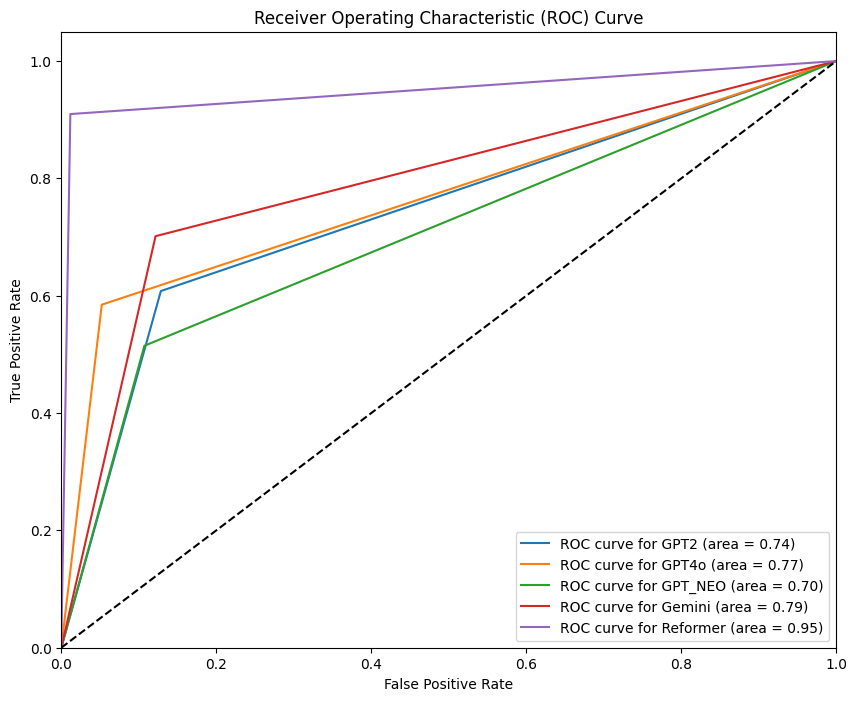

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Convert the true labels and predicted labels to their one-hot encoded (binarized) form
y_true_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
y_pred_binarized = label_binarize(preds, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
